# Modeling Notebook

## Baseline Models

In [2]:
# import data
import pandas as pd

data = pd.read_csv("data/cleaned_data_baseline.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 165 entries, application_order to father_job_Workers in food processing, woodworking, clothing and other industries and crafts
dtypes: float64(10), int64(155)
memory usage: 5.6 MB


### Preparing Data

In [3]:
X = data.drop(columns=["target"])
y = data["target"]

X.shape, y.shape

((4424, 164), (4424,))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape

((3539, 164), (885, 164))

## Training Baseline Models

#### Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.6757062146892655

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

dt_predictions = dt.predict(X_test)
print({"Enrolled": 1, "Dropout": 0, "Graduate": 2})
confusion_matrix(y_test, dt_predictions, normalize="true")

{'Enrolled': 1, 'Dropout': 0, 'Graduate': 2}


array([[0.63291139, 0.21518987, 0.15189873],
       [0.26490066, 0.36423841, 0.37086093],
       [0.08373206, 0.09569378, 0.82057416]])

#### Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB

naive_classifier = GaussianNB()
naive_classifier.fit(X_train, y_train)
naive_classifier.score(X_test, y_test)

0.3649717514124294

In [8]:
naive_predictions = naive_classifier.predict(X_test)
confusion_matrix(y_test, naive_predictions)

array([[309,   6,   1],
       [139,  10,   2],
       [399,  15,   4]], dtype=int64)

#### XGBoost

In [9]:
from xgboost import XGBClassifier

xgboost_classifier = XGBClassifier(random_state=42)
xgboost_classifier.fit(X_train, y_train)
xgboost_classifier.score(X_test, y_test)

0.7638418079096045

In [10]:
xg_predictions = xgboost_classifier.predict(X_test)
confusion_matrix(y_test, xg_predictions)

array([[235,  40,  41],
       [ 39,  55,  57],
       [ 12,  20, 386]], dtype=int64)

## Baseline Models with Binary Classifier

The more advanced models tend to error on the side of missing those who actually do dropout.

Our first attempts at fitting a binary classifier all were overfit. To reduce this we can make our trees smaller or use less features in each bootstrapped model for the Random Forest

In [11]:
y = y.map({2: 0, 1: 0, 0: 1})
y.value_counts()

target
0    3003
1    1421
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape

((3539, 164), (885, 164))

### Decision Tree

In [13]:
dt_binary = DecisionTreeClassifier(random_state=42)
dt_binary.fit(X_train, y_train)
dt_binary.score(X_test, y_test)

0.7909604519774012

In [14]:
dt_binary_predictions = dt_binary.predict(X_test)
print(dt_binary.score(X_train, y_train))
confusion_matrix(y_test, dt_binary_predictions)

1.0


array([[483,  86],
       [ 99, 217]], dtype=int64)

In [15]:
print(classification_report(y_test, dt_binary_predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       569
           1       0.72      0.69      0.70       316

    accuracy                           0.79       885
   macro avg       0.77      0.77      0.77       885
weighted avg       0.79      0.79      0.79       885



### XGBoost

In [16]:
xgboost_binary = XGBClassifier(random_state=42)
xgboost_binary.fit(X_train, y_train)
xgboost_binary.score(X_test, y_test)

0.8497175141242937

In [17]:
xgboost_binary_predictions = xgboost_binary.predict(X_test)
print(xgboost_binary.score(X_train, y_train))
confusion_matrix(y_test, xgboost_binary_predictions)

0.9980220401243289


array([[526,  43],
       [ 90, 226]], dtype=int64)

In [18]:
print(classification_report(y_test, xgboost_binary_predictions))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       569
           1       0.84      0.72      0.77       316

    accuracy                           0.85       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.85      0.85       885



### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_binary = RandomForestClassifier(random_state=42)
rf_binary.fit(X_train, y_train)
rf_binary.score(X_test, y_test)

0.8542372881355932

In [20]:
rf_predictions = rf_binary.predict(X_test)
print(rf_binary.score(X_train, y_train))
confusion_matrix(y_test, rf_predictions)

1.0


array([[538,  31],
       [ 98, 218]], dtype=int64)

In [21]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89       569
           1       0.88      0.69      0.77       316

    accuracy                           0.85       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.85      0.85       885



### Support Vector Machine

In [22]:
from sklearn.svm import SVC

svc = SVC(C=0.3, random_state=42, probability=True)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(classification_report(y_test, svc.predict(X_test)))

0.8185928228313083
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       569
           1       0.86      0.48      0.62       316

    accuracy                           0.79       885
   macro avg       0.82      0.72      0.73       885
weighted avg       0.80      0.79      0.77       885



### ROC Curves

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use([i for i in plt.style.available if "seaborn" in i][0])

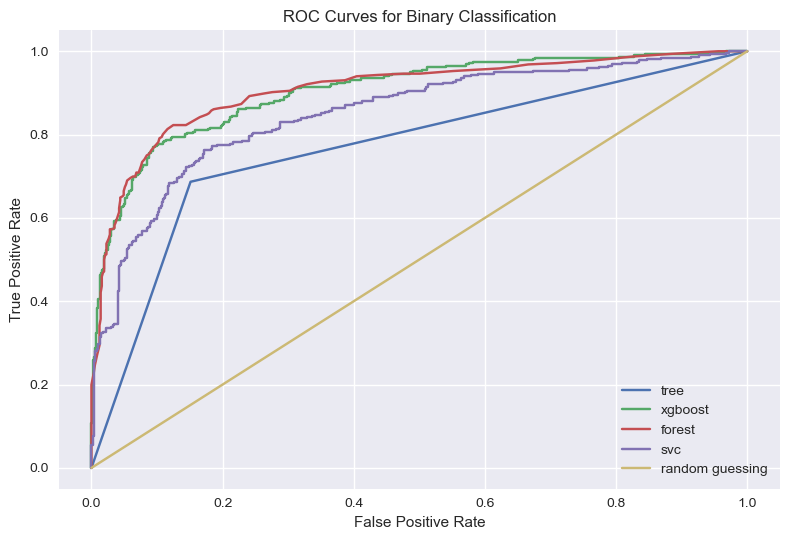

In [24]:
fig, ax = plt.subplots()

for name, model in [("tree", dt_binary), ("xgboost", xgboost_binary), ("forest", rf_binary), ("svc", svc)]:
    # get data for curve
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)

    # plot curve
    ax.plot(fpr, tpr, label=name)

# some labels
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label="random guessing")
ax.set_title("ROC Curves for Binary Classification")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.tight_layout()

## Fighting Overfitting XGBoost


With XGBoost there are some tecniques that can be used for tunnig the model

### Hyperparameter tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
param_grid = {
    'max_depth':[3,5,7],
    'learning_rate':[0.01, 0.1,0.2],
    'n_estimators':[100,200,300],
    'subsample':[0.8,0.9,1.0],
    'colsample_bytree':[0.8, 1.0]
}
xgboost_binary_hyper =  XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator = xgboost_binary_hyper, param_grid = param_grid, 
                           scoring = 'accuracy', cv = 5, verbose =1)

In [27]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\ksongire\AppData\Local\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [28]:
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [29]:
best_model_xg = grid_search.best_estimator_
y_pred_xg = best_model_xg.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_xg = accuracy_score(y_test,y_pred_xg)
print("Accuracy with adjusted hyperparameters: ",accuracy_xg)
#improve of 0.05

Accuracy with adjusted hyperparameters:  0.8553672316384181


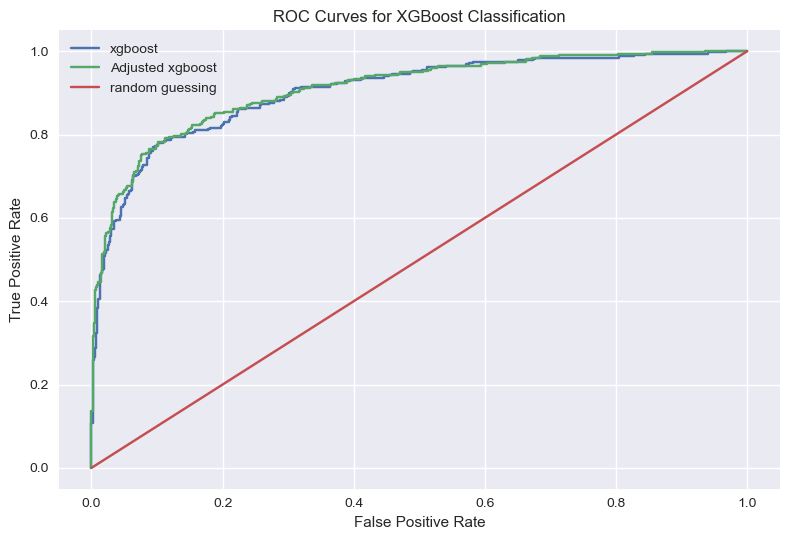

In [31]:
figx, ax = plt.subplots()
for name, model in [("xgboost", xgboost_binary), ("Adjusted xgboost", grid_search)]:
    # get data for curve
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    ax.plot(fpr, tpr, label=name)

# some labels
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label="random guessing")
ax.set_title("ROC Curves for XGBoost Classification")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.tight_layout()

## Fighting Overfitting Random Forest

With the Random Forest model, there are some easy to tune parameters to avoid overly deep trees

### Attempted Grid Search

This was not successful because the parameters I tried were worse than defaults.

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    "max_depth": [5, 10, 15, 30, 60],
    "ccp_alpha": [0.0, 0.1, 0.3, 0.6],
    "min_samples_split": [5, 15, 30]
}
tuned_forest = GridSearchCV(forest, param_grid)

In [34]:
tuned_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.3, 0.6],
                         'max_depth': [5, 10, 15, 30, 60],
                         'min_samples_split': [5, 15, 30]})

In [35]:
tuned_forest.best_params_

{'ccp_alpha': 0.0, 'max_depth': 15, 'min_samples_split': 5}

In [36]:
tuned_forest.score(X_test, y_test)

0.8519774011299435

### Some Standardization on Data

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [38]:
standard_scaler = StandardScaler()
forest = RandomForestClassifier(random_state=42)
standardized_forest = make_pipeline(standard_scaler, forest)

In [39]:
standardized_forest.fit(X_train, y_train)
standardized_forest.score(X_test, y_test)

0.8508474576271187

In [40]:
print(classification_report(y_test, standardized_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       569
           1       0.87      0.68      0.77       316

    accuracy                           0.85       885
   macro avg       0.86      0.81      0.83       885
weighted avg       0.85      0.85      0.85       885



TypeError: unhashable type: 'dict_keys'

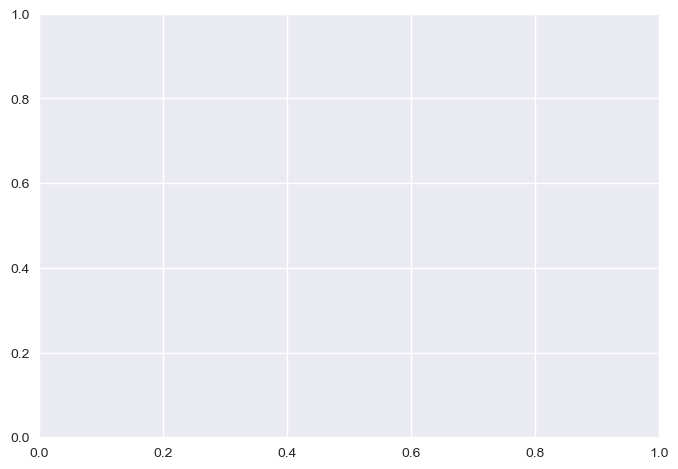

In [41]:
importance = standardized_forest.named_steps["randomforestclassifier"]\
    .feature_importances_
importance = dict(sorted(zip(X.columns, importance), key=lambda x: x[1]))
importance = dict(filter(lambda x: x[1] > 0.01, importance.items()))

plt.barh(importance.keys(), importance.values())
plt.show()

### Try GridSearch on Standardized Data

In [ ]:
standard_scaler = StandardScaler()

# grid search
param_grid = {
    "max_depth": [5, 10, 15, 30, 60],
    "ccp_alpha": [0.0, 0.1, 0.3, 0.6],
    "min_samples_split": [5, 15, 30]
}
forest = RandomForestClassifier(random_state=42)
tuned_forest = GridSearchCV(forest, param_grid, refit=True)
standardized_tuned_forest = make_pipeline(standard_scaler, tuned_forest)

In [ ]:
standardized_tuned_forest.fit(X_train, y_train)
standardized_tuned_forest.score(X_test, y_test)

In [ ]:
print(classification_report(y_test, standardized_tuned_forest.predict(X_test)))

### Try Class Imbalance Tuning

In [ ]:
y.value_counts(normalize=True)

In [ ]:
class_imbalance_forest = RandomForestClassifier(random_state=42, class_weight={0:7, 1:3})
class_imbalance_forest.fit(X_train, y_train)

In [ ]:
class_imbalance_forest.score(X_test, y_test)

Similar Idea but with Data Standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
class_imbalance_forest = RandomForestClassifier(random_state=42, class_weight={0:7, 1:3})
pipeline = make_pipeline(scaler, class_imbalance_forest)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

In [ ]:
print(classification_report(y_test, pipeline.predict(X_test)))

### Plotting Improvements

In [ ]:
fig2, ax = plt.subplots()

for name, model in [("forest", rf_binary), ("tuned forest", pipeline)]:
    # get data for curve
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)

    # plot curve
    ax.plot(fpr, tpr, label=name)

# some labels
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label="random guessing")
ax.set_title("ROC Curves for Binary Classification")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.tight_layout()

## Final Model

This Model uses a base Random Forest with default parameters and class imbalance tuning. Then it uses a dataset where some features have been binned and features with near no feature importance have been dropped. This mode has 0.85 accuracy with an improved recall at 0.73 by using a dataset with 53 features.

In [ ]:
engineered_data = pd.read_csv("data/feature_engineering.csv")
engineered_data.info()

In [ ]:
x, y = engineered_data[[i for i in engineered_data.columns if i != "target"]], engineered_data["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
forest = RandomForestClassifier(random_state=42, class_weight={0:7, 1:3})

In [ ]:
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

In [ ]:
print(classification_report(y_test, forest.predict(x_test)))

In [ ]:
importance = forest.feature_importances_
importance = dict(sorted(zip(X.columns, importance), key=lambda x: x[1]))
importance = dict(filter(lambda x: x[1] > 0.01, importance.items()))

# plot the feature importance
plt.barh(importance.keys(), importance.values())
plt.title("Feature Importance for Final Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('plots/FetureImportance.png', dpi = 100)
plt.show()